In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import csv
from matplotlib.colors import Normalize


## 必要な関数の定義
書き加えた部分だよ


In [3]:
def rbyA(A):
    r = -np.log(A)
    return r

def Fzanf(A):
    r = rbyA(A)
    Fz = np.exp(-1+np.log(1.5))*np.exp(-0.5*np.log(r))
    return Fz

def dFzdAanf(A):
    r = rbyA(A)
    d = np.exp(-1 + np.log(1.5))*np.exp(-0.5*np.log(r))*(-0.5/r)*(-1/A)
    return d

def rbyB(B):
    r = 0.5*np.log(2) - np.log(B)
    return r

def alphaanf(B):
    r = rbyB(B)
    alpha = 1 - np.exp(-(1 + 0.5*np.log(r) - r - np.log(1.5)))
    return alpha

def dalphadBanf(B):
    r =rbyB(B)
    d = ((0.5/r) - 1)*np.exp(-(1 + 0.5*np.log(r) - r - np.log(1.5)))*(-1/B)
    return d

## Reconstructioの関数

In [4]:
def reconstrction_7point(Nx,Ny,Aobs,Bxobs,Byobs,Bzobs,alphapobs,Fzobs):
    Lx = Nx-1
    Ly = Ny-1
    Bobs = np.sqrt(Bxobs**2 + Byobs**2 + Bzobs**2)

    #パラメータ設定-
    delBxdelxtmp = np.zeros((Nx))
    del2Adelx2tmp = np.zeros((Nx))
    delBdelxtmp = np.zeros((Nx))
    Apn = np.zeros((Nx))
    Bxpn = np.zeros((Nx))
    Bzpn = np.zeros((Nx))
    Bypn = np.zeros((Nx))
    
    Arec = np.empty((Ny,Nx))
    Bxrec = np.empty((Ny,Nx))
    Byrec = np.empty((Ny,Nx))
    Bzrec = np.empty((Ny,Nx))
    Brec = np.empty((Ny,Nx))
    alpharec = np.empty((Ny,Nx))
    Fzrec = np.empty((Ny,Nx))
    delBxdelxrec = np.empty((Ny,Nx))
    del2Adelx2rec = np.empty((Ny,Nx))
    delBdelxrec = np.empty((Ny,Nx))
    del2Adely2rec = np.empty((Ny,Nx))
    delBzdelyrec = np.empty((Ny,Nx))
    
    Arec[ycenter,:] = Aobs
    Bxrec[ycenter,:] = Bxobs
    Byrec[ycenter,:] = Byobs
    Bzrec[ycenter,:] = Bzobs
    Brec[ycenter,:] = Bobs
    alpharec[ycenter,:] = alphaobs
    Fzrec[ycenter,:] = Fzobs
    
    Mtmp = np.empty((Nx,2,2))
    Mtmpinv11 = np.empty((Nx))
    Mtmpinv12 = np.empty((Nx))
    Mtmpinv21 = np.empty((Nx))
    Mtmpinv22 = np.empty((Nx))
    
    i = np.arange(1,Lx)#x方向のグリッドの端0とLxを除いた分の配列 1~Lx-1
    i7 = np.arange(3,Lx-2)#3~Lx-3、スムージング用
    
    Aprev = Aobs
    Bxprev = Bxobs
    Byprev = Byobs
    Bzprev = Bzobs
    Bprev = Bobs
    alphaprev = alphaobs
    Fzprev = Fzobs
    dFzdAprev = dFzdAanf(Aobs)
    dalphadBprev = dalphadBanf(Bobs)
    
    
    for j in range(1,ycenter+1):#j = 1~ycenter,stepnumber
        #x-difference
        delBxdelxtmp[i] = (Bxprev[i+1] - Bxprev[i-1])/(2*deltax)
        del2Adelx2tmp[i] = (Aprev[i+1] - 2*Aprev[i] + Aprev[i-1])/(deltax**2)
        delBdelxtmp[i] = (Bprev[i+1] - Bprev[i-1])/(2*deltax)
        
        delBxdelxtmp[0] = (1/6)*(-11*Bxprev[0] + 18*Bxprev[1] - 9*Bxprev[2] + 2*Bxprev[3])/deltax
        delBxdelxtmp[Lx] = (1/6)*(11*Bxprev[Lx] - 18*Bxprev[Lx-1] + 9*Bxprev[Lx-2] - 2*Bxprev[Lx-3])/deltax
        del2Adelx2tmp[0] = (2*Aprev[0] - 5*Aprev[1] + 4*Aprev[2] - Aprev[3])/(deltax**2)
        del2Adelx2tmp[Lx] = (2*Aprev[Lx] - 5*Aprev[Lx-1] + 4*Aprev[Lx-2] - Aprev[Lx-3])/(deltax**2)
        delBdelxtmp[0] = (1/6)*(-11*Bprev[0] + 18*Bprev[1] - 9*Bprev[2] + 2*Bprev[3])/deltax
        delBdelxtmp[Lx] = (1/6)*(11*Bprev[Lx] - 18*Bprev[Lx-1] + 9*Bprev[Lx-2] - 2*Bprev[Lx-3])/deltax 
        
        
        #Matrix
        Y1tmp = -(1-alphaprev)*del2Adelx2tmp - Byprev*dalphadBprev*delBdelxtmp - (Bxprev*Byprev/Bprev)*dalphadBprev*delBxdelxtmp - Bzprev*dFzdAprev
        Y2tmp = -(Byprev*Bzprev/Bprev)*dalphadBprev*delBxdelxtmp + Bxprev*dFzdAprev
        M11tmp = (1-alphaprev) - ((Bxprev**2)/Bprev)*dalphadBprev
        M12tmp = -(Bxprev*Bzprev/Bprev)*dalphadBprev
        M22tmp = (1-alphaprev) - ((Bzprev**2)/Bprev)*dalphadBprev
        
        Mtmp[:,0,0] = M11tmp[:]
        Mtmp[:,0,1] = M12tmp[:]
        Mtmp[:,1,0] = M12tmp[:]
        Mtmp[:,1,1] = M22tmp[:]
        
        Mtmpinv = np.linalg.inv(Mtmp)
        
        Mtmpinv11[:] = Mtmpinv[:,0,0]
        Mtmpinv12[:] = Mtmpinv[:,0,1]
        Mtmpinv21[:] = Mtmpinv[:,1,0]
        Mtmpinv22[:] = Mtmpinv[:,1,1]
        
        #y-difference
        del2Adely2tmp = Mtmpinv11*Y1tmp + Mtmpinv12*Y2tmp
        delBzdelytmp = Mtmpinv21*Y1tmp + Mtmpinv22*Y2tmp
        
        
        Apn  = Aprev + deltay*Bxprev + 0.5*(deltay**2)*del2Adely2tmp
        Bxpn = Bxprev + deltay*del2Adely2tmp
        Bzpn = Bzprev + deltay*delBzdelytmp
        
        #boundary conditionで0と999を補う
        Apn[0] = 4*Apn[1] - 6*Apn[2] + 4*Apn[3] - Apn[4]
        Apn[Lx] = 4*Apn[Lx-1] - 6*Apn[Lx-2] + 4*Apn[Lx-3] - Apn[Lx-4]
        Bxpn[0] = 4*Bxpn[1] - 6*Bxpn[2] + 4*Bxpn[3] - Bxpn[4]
        Bxpn[Lx] = 4*Bxpn[Lx-1] - 6*Bxpn[Lx-2] + 4*Bxpn[Lx-3] - Bxpn[Lx-4]
        Bzpn[0] = 4*Bzpn[1] - 6*Bzpn[2] + 4*Bzpn[3] - Bzpn[4]
        Bzpn[Lx] = 4*Bzpn[Lx-1] - 6*Bzpn[Lx-2] + 4*Bzpn[Lx-3] - Bzpn[Lx-4]   
        
        #smoothing
        Apn[i7] = (1/7)*(Apn[i7-3] + Apn[i7-2] + Apn[i7-1] + Apn[i7] + Apn[i7+1] + Apn[i7+2] + Apn[i7+3])
        Bxpn[i7] = (1/7)*(Bxpn[i7-3] + Bxpn[i7-2] + Bxpn[i7-1] + Bxpn[i7] + Bxpn[i7+1] + Bxpn[i7+2] + Bxpn[i7+3])
        Bzpn[i7] = (1/7)*(Bzpn[i7-3] + Bzpn[i7-2] + Bzpn[i7-1] + Bzpn[i7] + Bzpn[i7+1] + Bzpn[i7+2] + Bzpn[i7+3])
        
        #boundary condition
        Apn[2] = 4*Apn[3] - 6*Apn[4] + 4*Apn[5] - Apn[6]
        Apn[Lx-2] = 4*Apn[Lx-3] - 6*Apn[Lx-4] + 4*Apn[Lx-5] - Apn[Lx-6]
        Apn[1] = 4*Apn[2] - 6*Apn[3] + 4*Apn[4] - Apn[5]
        Apn[Lx-1] = 4*Apn[Lx-2] - 6*Apn[Lx-3] + 4*Apn[Lx-4] - Apn[Lx-5]
        Apn[0] = 4*Apn[1] - 6*Apn[2] + 4*Apn[3] - Apn[4]
        Apn[Lx] = 4*Apn[Lx-1] - 6*Apn[Lx-2] + 4*Apn[Lx-3] - Apn[Lx-4]
        Bxpn[2] = 4*Bxpn[3] - 6*Bxpn[4] + 4*Bxpn[5] - Bxpn[6]
        Bxpn[Lx-2] = 4*Bxpn[Lx-3] - 6*Bxpn[Lx-4] + 4*Bxpn[Lx-5] - Bxpn[Lx-6]
        Bxpn[1] = 4*Bxpn[2] - 6*Bxpn[3] + 4*Bxpn[4] - Bxpn[5]
        Bxpn[Lx-1] = 4*Bxpn[Lx-2] - 6*Bxpn[Lx-3] + 4*Bxpn[Lx-4] - Bxpn[Lx-5]
        Bxpn[0] = 4*Bxpn[1] - 6*Bxpn[2] + 4*Bxpn[3] - Bxpn[4]
        Bxpn[Lx] = 4*Bxpn[Lx-1] - 6*Bxpn[Lx-2] + 4*Bxpn[Lx-3] - Bxpn[Lx-4]
        Bzpn[2] = 4*Bzpn[3] - 6*Bzpn[4] + 4*Bzpn[5] - Bzpn[6]
        Bzpn[Lx-2] = 4*Bzpn[Lx-3] - 6*Bzpn[Lx-4] + 4*Bzpn[Lx-5] - Bzpn[Lx-6]
        Bzpn[1] = 4*Bzpn[2] - 6*Bzpn[3] + 4*Bzpn[4] - Bzpn[5]
        Bzpn[Lx-1] = 4*Bzpn[Lx-2] - 6*Bzpn[Lx-3] + 4*Bzpn[Lx-4] - Bzpn[Lx-5] 
        Bzpn[0] = 4*Bzpn[1] - 6*Bzpn[2] + 4*Bzpn[3] - Bzpn[4]
        Bzpn[Lx] = 4*Bzpn[Lx-1] - 6*Bzpn[Lx-2] + 4*Bzpn[Lx-3] - Bzpn[Lx-4]  
        
        #By
        Bypn[i] = -(Apn[i+1] -Apn[i-1])/(2*deltax)
        Bypn[0] = -(1/6)*(-11*Apn[0] + 18*Apn[1] - 9*Apn[2] + 2*Apn[3])/deltax
        Bypn[Lx] = -(1/6)*(11*Apn[Lx] - 18*Apn[Lx-1] + 9*Apn[Lx-2] - 2*Apn[Lx-3])/deltax
        #Smoothing
        Bypn[i7] = (1/7)*(Bypn[i7-3] + Bypn[i7-2] + Bypn[i7-1] + Bypn[i7] + Bypn[i7+1] + Bypn[i7+2] + Bypn[i7+3])
        #boundary condition
        Bypn[2] = 4*Bypn[3] - 6*Bypn[4] + 4*Bypn[5] - Bypn[6]
        Bypn[Lx-2] = 4*Bypn[Lx-3] - 6*Bypn[Lx-4] + 4*Bypn[Lx-5] - Bypn[Lx-6]
        Bypn[1] = 4*Bypn[2] - 6*Bypn[3] + 4*Bypn[4] - Bypn[5]
        Bypn[Lx-1] = 4*Bypn[Lx-2] - 6*Bypn[Lx-3] + 4*Bypn[Lx-4] - Bypn[Lx-5]
        Bypn[0] = 4*Bypn[1] - 6*Bypn[2] + 4*Bypn[3] - Bypn[4]
        Bypn[Lx] = 4*Bypn[Lx-1] - 6*Bypn[Lx-2] + 4*Bypn[Lx-3] - Bypn[Lx-4]
        
        Bpn = np.sqrt(Bxpn**2 + Bypn**2 + Bzpn**2)
        alphapn = alphaanf(Bpn)
        Fzpn = (1 - alphapn)*Bzpn
        
        
        Arec[ycenter+j,:] = Apn[:]
        Bxrec[ycenter+j,:] = Bxpn[:]
        Byrec[ycenter+j,:] = Bypn[:]
        Bzrec[ycenter+j,:] = Bzpn[:]
        Brec[ycenter+j,:]  = Bpn[:]
        alpharec[ycenter+j,:] = alphapn[:]
        Fzrec[ycenter+j,:] = Fzpn[:]
        #各方向への差分で求めた微分の値は、その場での値
        delBxdelxrec[ycenter+j-1,:] = delBxdelxtmp[:] 
        del2Adelx2rec[ycenter+j-1,:] = del2Adelx2tmp[:]
        delBdelxrec[ycenter+j-1,:] = delBdelxtmp[:]
        del2Adely2rec[ycenter+j-1,:] = del2Adely2tmp[:] 
        delBzdelyrec[ycenter+j-1,:] = delBzdelytmp[:] 
        
        Aprev = Apn
        Bxprev = Bxpn
        Byprev = Bypn
        Bzprev = Bzpn
        Bprev = Bpn
        alphaprev = alphapn
        Fzprev = Fzpn
        dFzdAprev = dFzdAanf(Apn)
        dalphadBprev = dalphadBanf(Bpn)
#繰り返しここまで-------------------------------------------------------------------    

    return Arec,Bxrec,Byrec,Bzrec,Brec,alpharec,Fzrec,delBxdelxrec,del2Adelx2rec,delBdelxrec,del2Adely2rec,delBzdelyrec

## y軸の負の方向への計算

In [5]:
def reconstrction_minus_7point(Nx,Ny,Aobs,Bxobs,Byobs,Bzobs,alphapobs,Fzobs):
    Lx = Nx-1
    Ly = Ny-1
    Bobs = np.sqrt(Bxobs**2 + Byobs**2 + Bzobs**2)

    #パラメータ設定-
    delBxdelxtmp = np.zeros((Nx))
    del2Adelx2tmp = np.zeros((Nx))
    delBdelxtmp = np.zeros((Nx))
    Apn = np.zeros((Nx))
    Bxpn = np.zeros((Nx))
    Bzpn = np.zeros((Nx))
    Bypn = np.zeros((Nx))
    
    Arec = np.empty((Ny,Nx))
    Bxrec = np.empty((Ny,Nx))
    Byrec = np.empty((Ny,Nx))
    Bzrec = np.empty((Ny,Nx))
    Brec = np.empty((Ny,Nx))
    alpharec = np.empty((Ny,Nx))
    Fzrec = np.empty((Ny,Nx))
    delBxdelxrec = np.empty((Ny,Nx))
    del2Adelx2rec = np.empty((Ny,Nx))
    delBdelxrec = np.empty((Ny,Nx))
    del2Adely2rec = np.empty((Ny,Nx))
    delBzdelyrec = np.empty((Ny,Nx))
    
    Arec[ycenter,:] = Aobs
    Bxrec[ycenter,:] = Bxobs
    Byrec[ycenter,:] = Byobs
    Bzrec[ycenter,:] = Bzobs
    Brec[ycenter,:] = Bobs
    alpharec[ycenter,:] = alphaobs
    Fzrec[ycenter,:] = Fzobs
    
    Mtmp = np.empty((Nx,2,2))
    Mtmpinv11 = np.empty((Nx))
    Mtmpinv12 = np.empty((Nx))
    Mtmpinv21 = np.empty((Nx))
    Mtmpinv22 = np.empty((Nx))
    
    i = np.arange(1,Lx)#x方向のグリッドの端0とLxを除いた分の配列 1~Lx-1
    i7 = np.arange(3,Lx-2)#3~Lx-3,スムージングの際に使う
    
    Aprev = Aobs
    Bxprev = Bxobs
    Byprev = Byobs
    Bzprev = Bzobs
    Bprev = Bobs
    alphaprev = alphaobs
    Fzprev = Fzobs
    dFzdAprev = dFzdAanf(Aobs)
    dalphadBprev = dalphadBanf(Bobs)
    
    
    for j in range(1,ycenter+1):#j = 1~ycenter,stepnumber
        #x-difference
        delBxdelxtmp[i] = (Bxprev[i+1] - Bxprev[i-1])/(2*deltax)
        del2Adelx2tmp[i] = (Aprev[i+1] - 2*Aprev[i] + Aprev[i-1])/(deltax**2)
        delBdelxtmp[i] = (Bprev[i+1] - Bprev[i-1])/(2*deltax)
        
        delBxdelxtmp[0] = (1/6)*(-11*Bxprev[0] + 18*Bxprev[1] - 9*Bxprev[2] + 2*Bxprev[3])/deltax
        delBxdelxtmp[Lx] = (1/6)*(11*Bxprev[Lx] - 18*Bxprev[Lx-1] + 9*Bxprev[Lx-2] - 2*Bxprev[Lx-3])/deltax
        del2Adelx2tmp[0] = (2*Aprev[0] - 5*Aprev[1] + 4*Aprev[2] - Aprev[3])/(deltax**2)
        del2Adelx2tmp[Lx] = (2*Aprev[Lx] - 5*Aprev[Lx-1] + 4*Aprev[Lx-2] - Aprev[Lx-3])/(deltax**2)
        delBdelxtmp[0] = (1/6)*(-11*Bprev[0] + 18*Bprev[1] - 9*Bprev[2] + 2*Bprev[3])/deltax
        delBdelxtmp[Lx] = (1/6)*(11*Bprev[Lx] - 18*Bprev[Lx-1] + 9*Bprev[Lx-2] - 2*Bprev[Lx-3])/deltax 
        
        
        #Matrix
        Y1tmp = -(1-alphaprev)*del2Adelx2tmp - Byprev*dalphadBprev*delBdelxtmp - (Bxprev*Byprev/Bprev)*dalphadBprev*delBxdelxtmp - Bzprev*dFzdAprev
        Y2tmp = -(Byprev*Bzprev/Bprev)*dalphadBprev*delBxdelxtmp + Bxprev*dFzdAprev
        M11tmp = (1-alphaprev) - ((Bxprev**2)/Bprev)*dalphadBprev
        M12tmp = -(Bxprev*Bzprev/Bprev)*dalphadBprev
        M22tmp = (1-alphaprev) - ((Bzprev**2)/Bprev)*dalphadBprev
        
        Mtmp[:,0,0] = M11tmp[:]
        Mtmp[:,0,1] = M12tmp[:]
        Mtmp[:,1,0] = M12tmp[:]
        Mtmp[:,1,1] = M22tmp[:]
        
        Mtmpinv = np.linalg.inv(Mtmp)
        
        Mtmpinv11[:] = Mtmpinv[:,0,0]
        Mtmpinv12[:] = Mtmpinv[:,0,1]
        Mtmpinv21[:] = Mtmpinv[:,1,0]
        Mtmpinv22[:] = Mtmpinv[:,1,1]
        
        #y-difference
        del2Adely2tmp = Mtmpinv11*Y1tmp + Mtmpinv12*Y2tmp
        delBzdelytmp = Mtmpinv21*Y1tmp + Mtmpinv22*Y2tmp
        
        
        Apn  = Aprev - deltay*Bxprev + 0.5*(deltay**2)*del2Adely2tmp
        Bxpn = Bxprev - deltay*del2Adely2tmp
        Bzpn = Bzprev - deltay*delBzdelytmp
        
        #boundary conditionで0と999を補う
        Apn[0] = 4*Apn[1] - 6*Apn[2] + 4*Apn[3] - Apn[4]
        Apn[Lx] = 4*Apn[Lx-1] - 6*Apn[Lx-2] + 4*Apn[Lx-3] - Apn[Lx-4]
        Bxpn[0] = 4*Bxpn[1] - 6*Bxpn[2] + 4*Bxpn[3] - Bxpn[4]
        Bxpn[Lx] = 4*Bxpn[Lx-1] - 6*Bxpn[Lx-2] + 4*Bxpn[Lx-3] - Bxpn[Lx-4]
        Bzpn[0] = 4*Bzpn[1] - 6*Bzpn[2] + 4*Bzpn[3] - Bzpn[4]
        Bzpn[Lx] = 4*Bzpn[Lx-1] - 6*Bzpn[Lx-2] + 4*Bzpn[Lx-3] - Bzpn[Lx-4]   
        
        #smoothing
        Apn[i7] = (1/7)*(Apn[i7-3] + Apn[i7-2] + Apn[i7-1] + Apn[i7] + Apn[i7+1] + Apn[i7+2] + Apn[i7+3])
        Bxpn[i7] = (1/7)*(Bxpn[i7-3] + Bxpn[i7-2] + Bxpn[i7-1] + Bxpn[i7] + Bxpn[i7+1] + Bxpn[i7+2] + Bxpn[i7+3])
        Bzpn[i7] = (1/7)*(Bzpn[i7-3] + Bzpn[i7-2] + Bzpn[i7-1] + Bzpn[i7] + Bzpn[i7+1] + Bzpn[i7+2] + Bzpn[i7+3])
        
        #boundary condition
        Apn[2] = 4*Apn[3] - 6*Apn[4] + 4*Apn[5] - Apn[6]
        Apn[Lx-2] = 4*Apn[Lx-3] - 6*Apn[Lx-4] + 4*Apn[Lx-5] - Apn[Lx-6]
        Apn[1] = 4*Apn[2] - 6*Apn[3] + 4*Apn[4] - Apn[5]
        Apn[Lx-1] = 4*Apn[Lx-2] - 6*Apn[Lx-3] + 4*Apn[Lx-4] - Apn[Lx-5]
        Apn[0] = 4*Apn[1] - 6*Apn[2] + 4*Apn[3] - Apn[4]
        Apn[Lx] = 4*Apn[Lx-1] - 6*Apn[Lx-2] + 4*Apn[Lx-3] - Apn[Lx-4]
        Bxpn[2] = 4*Bxpn[3] - 6*Bxpn[4] + 4*Bxpn[5] - Bxpn[6]
        Bxpn[Lx-2] = 4*Bxpn[Lx-3] - 6*Bxpn[Lx-4] + 4*Bxpn[Lx-5] - Bxpn[Lx-6]
        Bxpn[1] = 4*Bxpn[2] - 6*Bxpn[3] + 4*Bxpn[4] - Bxpn[5]
        Bxpn[Lx-1] = 4*Bxpn[Lx-2] - 6*Bxpn[Lx-3] + 4*Bxpn[Lx-4] - Bxpn[Lx-5]
        Bxpn[0] = 4*Bxpn[1] - 6*Bxpn[2] + 4*Bxpn[3] - Bxpn[4]
        Bxpn[Lx] = 4*Bxpn[Lx-1] - 6*Bxpn[Lx-2] + 4*Bxpn[Lx-3] - Bxpn[Lx-4]
        Bzpn[2] = 4*Bzpn[3] - 6*Bzpn[4] + 4*Bzpn[5] - Bzpn[6]
        Bzpn[Lx-2] = 4*Bzpn[Lx-3] - 6*Bzpn[Lx-4] + 4*Bzpn[Lx-5] - Bzpn[Lx-6]
        Bzpn[1] = 4*Bzpn[2] - 6*Bzpn[3] + 4*Bzpn[4] - Bzpn[5]
        Bzpn[Lx-1] = 4*Bzpn[Lx-2] - 6*Bzpn[Lx-3] + 4*Bzpn[Lx-4] - Bzpn[Lx-5] 
        Bzpn[0] = 4*Bzpn[1] - 6*Bzpn[2] + 4*Bzpn[3] - Bzpn[4]
        Bzpn[Lx] = 4*Bzpn[Lx-1] - 6*Bzpn[Lx-2] + 4*Bzpn[Lx-3] - Bzpn[Lx-4]  
        
        #By
        Bypn[i] = -(Apn[i+1] -Apn[i-1])/(2*deltax)
        Bypn[0] = -(1/6)*(-11*Apn[0] + 18*Apn[1] - 9*Apn[2] + 2*Apn[3])/deltax
        Bypn[Lx] = -(1/6)*(11*Apn[Lx] - 18*Apn[Lx-1] + 9*Apn[Lx-2] - 2*Apn[Lx-3])/deltax
        #Smoothing
        Bypn[i7] = (1/7)*(Bypn[i7-3] + Bypn[i7-2] + Bypn[i7-1] + Bypn[i7] + Bypn[i7+1] + Bypn[i7+2] + Bypn[i7+3])
        #boundary condition
        Bypn[2] = 4*Bypn[3] - 6*Bypn[4] + 4*Bypn[5] - Bypn[6]
        Bypn[Lx-2] = 4*Bypn[Lx-3] - 6*Bypn[Lx-4] + 4*Bypn[Lx-5] - Bypn[Lx-6]
        Bypn[1] = 4*Bypn[2] - 6*Bypn[3] + 4*Bypn[4] - Bypn[5]
        Bypn[Lx-1] = 4*Bypn[Lx-2] - 6*Bypn[Lx-3] + 4*Bypn[Lx-4] - Bypn[Lx-5]
        Bypn[0] = 4*Bypn[1] - 6*Bypn[2] + 4*Bypn[3] - Bypn[4]
        Bypn[Lx] = 4*Bypn[Lx-1] - 6*Bypn[Lx-2] + 4*Bypn[Lx-3] - Bypn[Lx-4]
        
        Bpn = np.sqrt(Bxpn**2 + Bypn**2 + Bzpn**2)
        alphapn = alphaanf(Bpn)
        Fzpn = (1 - alphapn)*Bzpn
        
        
        Arec[ycenter-j,:] = Apn[:]
        Bxrec[ycenter-j,:] = Bxpn[:]
        Byrec[ycenter-j,:] = Bypn[:]
        Bzrec[ycenter-j,:] = Bzpn[:]
        Brec[ycenter-j,:]  = Bpn[:]
        alpharec[ycenter-j,:] = alphapn[:]
        Fzrec[ycenter-j,:] = Fzpn[:]
        #各方向への差分で求めた微分の値は、その場での値
        delBxdelxrec[ycenter-j+1,:] = delBxdelxtmp[:] 
        del2Adelx2rec[ycenter-j+1,:] = del2Adelx2tmp[:]
        delBdelxrec[ycenter-j+1,:] = delBdelxtmp[:]
        del2Adely2rec[ycenter-j+1,:] = del2Adely2tmp[:] 
        delBzdelyrec[ycenter-j+1,:] = delBzdelytmp[:] 
        
        Aprev = Apn
        Bxprev = Bxpn
        Byprev = Bypn
        Bzprev = Bzpn
        Bprev = Bpn
        alphaprev = alphapn
        Fzprev = Fzpn
        dFzdAprev = dFzdAanf(Apn)
        dalphadBprev = dalphadBanf(Bpn)
#繰り返しここまで-------------------------------------------------------------------    

    return Arec,Bxrec,Byrec,Bzrec,Brec,alpharec,Fzrec,delBxdelxrec,del2Adelx2rec,delBdelxrec,del2Adely2rec,delBzdelyrec

## Reconstructionの関数に入れるobsの値や比較用の解析解の定義

In [6]:
#Analytical solutions-------------------------------------------------------------------------------
nx = 1000
ny = 1001
ycenter = int((ny-1)/2)
deltay = 0.6/(ny-1)
deltax = 1.0/nx

xan = np.linspace(1,2,nx)
yan = np.linspace(0.2,0.8,ny)
Xan,Yan = np.meshgrid(xan,yan)
Ran = np.sqrt(Xan**2 + Yan**2)
    
Aan = np.exp(-Ran)
Bxan = -(Yan/Ran)*np.exp(-Ran)
Byan =  (Xan/Ran)*np.exp(-Ran)
Bzan = np.exp(-Ran)
Ban = np.sqrt(2)*np.exp(-Ran)#実際にはBx,By,Bzから求める(Ban = np.sqrt(Bxan**2 + Byan**2 + Bzan**2))
alphaan = 1.0 - np.exp(-(1.0 + 0.5*np.log(Ran) - Ran - np.log(1.5)))
Fzan = np.exp(-1+np.log(1.5))*np.exp(-0.5*np.log(Ran))#実際にはalphaとBzから求める(Fz = (1 - alphaan)*Bzan) 

#x方向への微分の解析解
delBxdelxan = (Xan*Yan*(Ran+1)*np.exp(-Ran))/(Ran**3)
del2Adelx2an = (np.exp(-Ran)/Ran)*((Xan**2/(Ran**2))*(Ran+1) - 1)
delBdelxan = -np.sqrt(2)*Xan*np.exp(-Ran)/Ran
    
#y方向への微分の解析解
del2Adely2an = (np.exp(-Ran)/Ran)*((Yan**2/(Ran**2))*(Ran+1) - 1)
delBzdelyan = -(Yan/Ran)*np.exp(-Ran)
#----------------------------------------------------------------------------------------------------

Aobs = Aan[ycenter,:]
Bxobs = Bxan[ycenter,:]
Byobs = Byan[ycenter,:]
Bzobs = Bzan[ycenter,:]
Bobs = Ban[ycenter,:]
alphaobs = alphaan[ycenter,:]
Fzobs = Fzan[ycenter,:]
dFzdAobs = dFzdAanf(Aan[ycenter,:])
dalphadBobs = dalphadBanf(Ban[ycenter,:])


## 結果の代入

In [7]:
conc3 = reconstrction_7point(nx,ny,Aobs,Bxobs,Byobs,Bzobs,alphaobs,Fzobs)

Arec_7point = np.empty((1001,1000))
Bxrec_7point = np.empty((1001,1000))
Byrec_7point = np.empty((1001,1000))
Bzrec_7point = np.empty((1001,1000))
Brec_7point = np.empty((1001,1000))
alpharec_7point = np.empty((1001,1000))
Fzrec_7point = np.empty((1001,1000))
delBxdelxrec_7point = np.empty((1001,1000))
del2Adelx2rec_7point = np.empty((1001,1000))
delBdelxrec_7point = np.empty((1001,1000))
del2Adely2rec_7point = np.empty((1001,1000))
delBzdelyrec_7point = np.empty((1001,1000))

for k in range (501):#0~500
                Arec_7point[ycenter+k,:] = conc3[0][ycenter+k,:]
                Bxrec_7point[ycenter+k,:] = conc3[1][ycenter+k,:]
                Byrec_7point[ycenter+k,:] = conc3[2][ycenter+k,:]
                Bzrec_7point[ycenter+k,:] = conc3[3][ycenter+k,:]
                Brec_7point[ycenter+k,:] = conc3[4][ycenter+k,:]
                alpharec_7point[ycenter+k,:] = conc3[5][ycenter+k,:]
                Fzrec_7point[ycenter+k,:] = conc3[6][ycenter+k,:]
                delBxdelxrec_7point[ycenter+k,:] = conc3[7][ycenter+k,:]
                del2Adelx2rec_7point[ycenter+k,:] = conc3[8][ycenter+k,:]
                delBdelxrec_7point[ycenter+k,:] = conc3[9][ycenter+k,:]
                del2Adely2rec_7point[ycenter+k,:] = conc3[10][ycenter+k,:]
                delBzdelyrec_7point[ycenter+k,:] = conc3[11][ycenter+k,:]

In [8]:
conc3_minus = reconstrction_minus_7point(nx,ny,Aobs,Bxobs,Byobs,Bzobs,alphaobs,Fzobs)

for k in range (1,501):#1~500
                Arec_7point[ycenter-k,:] = conc3_minus[0][ycenter-k,:]
                Bxrec_7point[ycenter-k,:] = conc3_minus[1][ycenter-k,:]
                Byrec_7point[ycenter-k,:] = conc3_minus[2][ycenter-k,:]
                Bzrec_7point[ycenter-k,:] = conc3_minus[3][ycenter-k,:]
                Brec_7point[ycenter-k,:] = conc3_minus[4][ycenter-k,:]
                alpharec_7point[ycenter-k,:] = conc3_minus[5][ycenter-k,:]
                Fzrec_7point[ycenter-k,:] = conc3_minus[6][ycenter-k,:]
                delBxdelxrec_7point[ycenter-k,:] = conc3_minus[7][ycenter-k,:]
                del2Adelx2rec_7point[ycenter-k,:] = conc3_minus[8][ycenter-k,:]
                delBdelxrec_7point[ycenter-k,:] = conc3_minus[9][ycenter-k,:]
                del2Adely2rec_7point[ycenter-k,:] = conc3_minus[10][ycenter-k,:]
                delBzdelyrec_7point[ycenter-k,:] = conc3_minus[11][ycenter-k,:]
 

## 結果のプロット

C:\Users\Ryoya Shimada\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.


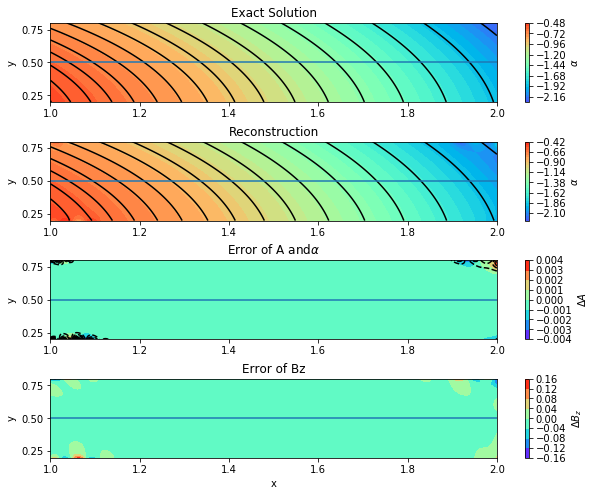

In [9]:
xtraj = Xan[500,:]
ytraj = np.empty((nx))
ytraj[:] = 0.5

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(411)
ax.contour(Xan,Yan,Aan,levels=20,colors='k')
alphacontour = ax.contourf(Xan,Yan,alphaan,levels=30,cmap='rainbow',norm=Normalize(vmin=-2.5,vmax=-0.3))
cbar = fig.colorbar(alphacontour)
cbar.ax.set_ylabel(r"$\alpha$")
ax.plot(xtraj,ytraj)
ax.set_ylabel('y')
ax.set_title('Exact Solution')

ax2 = fig.add_subplot(412)
ax2.contour(Xan,Yan,Arec_7point,levels=20,colors='k')
alphacontour2 = ax2.contourf(Xan,Yan,alpharec_7point,levels=30,cmap='rainbow',norm=Normalize(vmin=-2.5,vmax=-0.3))
cbar2 = fig.colorbar(alphacontour2)
cbar2.set_clim(-2.5,-0.3)
cbar2.ax.set_ylabel(r"$\alpha$")
ax2.plot(xtraj,ytraj)
ax2.set_ylabel('y')
ax2.set_title('Reconstruction')

errA = (Aan - Arec_7point)/Aan
erralpha = np.abs((alphaan - alpharec_7point))/alphaan
ax3 = fig.add_subplot(413)
ax3.plot(xtraj,ytraj)
e = ax3.contour(Xan,Yan,erralpha,levels=10,colors='k')
e.clabel()
eA = ax3.contourf(Xan,Yan,errA,cmap='rainbow')
cbar3 = fig.colorbar(eA)
cbar3.ax.set_ylabel(r"$\Delta A$")
#ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_title('Error of A and' r"$\alpha$")

errBz = (Bzan - Bzrec_7point)/Bzan
ax4 = fig.add_subplot(414)
ax4.plot(xtraj,ytraj)
eBz = ax4.contourf(Xan,Yan,errBz,cmap='rainbow')
cbar = fig.colorbar(eBz)
cbar.ax.set_ylabel(r"$\Delta B_z$")
fig.subplots_adjust(wspace=1.5,hspace=0.5)
ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.set_title('Error of Bz')

plt.show()


## これでReconstructionはBenchmarkに対して実行できたが、実際の観測値に対して当てはめるためにいろいろと変更を加えていく
まずはFzとBをBx,By,Bzとαから求める。その後、yの正負に対して入れ物となる配列の長さをきっちりと定義するところから始める。